In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import ta
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Creating a Ticker object for XMR-USD
xmr = yf.Ticker("XMR-USD")

# Downloading historical data for XMR-USD
# period="max" downloads data for the maximum available period
# interval="1d" downloads data at a daily interval
data = yf.download(tickers="XMR-USD", period="max", interval="1d")

data.head(10)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,112.531998,123.404999,112.219002,120.779999,120.779999,86864600
2017-11-10,121.344002,121.665001,101.757004,105.585999,105.585999,84614000
2017-11-11,105.750000,127.106003,103.877998,119.615997,119.615997,107708000
2017-11-12,119.597000,133.675003,110.617996,123.856003,123.856003,144948000
2017-11-13,128.960007,136.528000,120.921997,123.402000,123.402000,116200000
2017-11-14,123.615997,124.200996,118.625999,122.352997,122.352997,53544800
2017-11-15,122.240997,124.722000,119.192001,121.374001,121.374001,49976700
2017-11-16,121.242996,128.087997,118.504997,120.305000,120.305000,74944096
2017-11-17,120.014999,126.699997,119.250000,126.699997,126.699997,47127700


In [3]:
data_copy = data.copy()

In [4]:
# Define the start and end dates
start_date = "2017-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")  # Today's date

# Download data for each ticker
bitcoin_data = yf.download("BTC-USD", start=start_date, end=end_date)
gold_data = yf.download("GC=F", start=start_date, end=end_date)
silver_data = yf.download("SI=F", start=start_date, end=end_date)
copper_data = yf.download("HG=F", start=start_date, end=end_date)
usd_to_eur = yf.download("EURUSD=X", start=start_date, end=end_date)
sp500_data = yf.download("^GSPC", start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
datasets = {
    "gold_data": "GC=F",
    "silver_data": "SI=F",
    "copper_data": "HG=F",
    "usd_to_eur": "EURUSD=X",
    "sp500_data": "^GSPC",
    "bitcoin_data": "BTC-USD",
}

for df_name, suffix in datasets.items():
    data = data.merge(
        eval(df_name),
        how="left",
        left_index=True,
        right_index=True,
        suffixes=("", f"_{suffix}"),
    )
data

,Open,High,Low,Close,Adj Close,Volume,Open_GC=F,High_GC=F,Low_GC=F,Close_GC=F,...,Low_^GSPC,Close_^GSPC,Adj Close_^GSPC,Volume_^GSPC,Open_BTC-USD,High_BTC-USD,Low_BTC-USD,Close_BTC-USD,Adj Close_BTC-USD,Volume_BTC-USD
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-09,112.531998,123.404999,112.219002,120.779999,120.779999,86864600,1279.699951,1286.900024,1279.699951,1285.599976,...,2566.330078,2584.620117,2584.620117,3.844100e+09,7446.830078,7446.830078,7101.520020,7143.580078,7143.580078,3.226250e+09
2017-11-10,121.344002,121.665001,101.757004,105.585999,105.585999,84614000,1283.500000,1283.500000,1272.400024,1272.400024,...,2575.570068,2582.300049,2582.300049,3.489740e+09,7173.729980,7312.000000,6436.870117,6618.140137,6618.140137,5.208250e+09
2017-11-11,105.750000,127.106003,103.877998,119.615997,119.615997,107708000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6618.609863,6873.149902,6204.220215,6357.600098,6357.600098,4.908680e+09
2017-11-12,119.597000,133.675003,110.617996,123.856003,123.856003,144948000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6295.450195,6625.049805,5519.009766,5950.069824,5950.069824,8.957350e+09
2017-11-13,128.960007,136.528000,120.921997,123.402000,123.402000,116200000,1277.300049,1277.300049,1277.000000,1277.300049,...,2574.479980,2584.840088,2584.840088,3.405200e+09,5938.250000,6811.189941,5844.290039,6559.490234,6559.490234,6.263250e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-14,153.583801,154.282990,151.850967,152.833160,152.833160,33344438,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,26866.203125,26969.000000,26814.585938,26861.707031,26861.707031,5.388117e+09
2023-10-15,152.833466,153.465881,152.173126,152.448990,152.448990,31895675,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,26858.011719,27289.169922,26817.894531,27159.652344,27159.652344,7.098202e+09
2023-10-16,152.437531,153.522949,151.155411,152.544098,152.544098,64382308,1910.400024,1921.099976,1910.300049,1921.099976,...,4342.370117,4373.629883,4373.629883,3.409960e+09,27162.628906,29448.138672,27130.472656,28519.466797,28519.466797,2.783388e+10


In [6]:
# Adding new features to the data
data["MA5"] = (
    data["Close"].rolling(window=5).mean()
)  # Moving Average for the last 5 days
data["MA10"] = (
    data["Close"].rolling(window=10).mean()
)  # Moving Average for the last 10 days
data["MA15"] = (
    data["Close"].rolling(window=15).mean()
)  # Moving Average for the last 15 days
data["STD5"] = (
    data["Close"].rolling(window=5).std()
)  # Standard Deviation of the price in the last 5 days
data["STD10"] = (
    data["Close"].rolling(window=10).std()
)  # Standard Deviation of the price in the last 10 days
data["Prev_Return"] = data["Close"].pct_change()  # Previous day returns

data = data.dropna()  # Dropping rows with missing values
# Displaying the new features
data

,Open,High,Low,Close,Adj Close,Volume,Open_GC=F,High_GC=F,Low_GC=F,Close_GC=F,...,Close_BTC-USD,Adj Close_BTC-USD,Volume_BTC-USD,MA5,MA10,MA15,STD5,STD10,Prev_Return,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-24,158.619003,162.942001,156.761002,160.026993,160.026993,69178000,1286.699951,1286.699951,1286.699951,1286.699951,...,8253.690430,8253.690430,5.058610e+09,152.417398,139.074399,132.370466,12.948939,16.799975,0.008953,75.232413
2017-11-27,162.916000,173.391998,159.947998,173.391998,173.391998,81489696,1293.800049,1293.800049,1293.800049,1293.800049,...,9818.349609,9818.349609,5.653320e+09,164.768396,152.757298,142.780465,6.128826,16.599326,0.061319,76.283919
2017-11-28,175.348007,203.210007,173.173004,203.210007,203.210007,179179008,1294.699951,1294.699951,1294.699951,1294.699951,...,10058.799805,10058.799805,6.348820e+09,173.688998,159.998399,148.100999,17.263827,21.131367,0.171969,83.729532
2017-11-29,203.912994,214.274994,165.330994,168.149994,168.149994,178828000,1293.400024,1296.199951,1281.099976,1282.099976,...,9888.610352,9888.610352,1.156880e+10,175.313599,163.865498,151.154132,15.992126,18.270445,-0.172531,59.912286
2017-11-30,170.485992,195.393997,156.531006,180.138000,180.138000,128112000,1283.099976,1284.500000,1269.699951,1273.199951,...,10233.599609,10233.599609,8.310690e+09,177.652798,168.302798,155.071732,15.585964,15.925320,0.071294,63.713145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-11,152.220093,153.929443,150.970428,153.842102,153.842102,61162383,1869.500000,1874.599976,1869.099976,1872.800049,...,26873.320312,26873.320312,1.364809e+10,154.251324,151.669644,150.116331,1.517035,3.309191,0.010685,60.661343
2023-10-12,153.852783,154.344238,151.021347,152.341812,152.341812,65445853,1874.699951,1881.199951,1867.000000,1869.300049,...,26756.798828,26756.798828,9.392909e+09,153.677258,152.283482,150.510179,1.603191,2.694873,-0.009752,56.880581
2023-10-13,152.339523,154.368774,151.051971,153.590515,153.590515,51282283,1877.500000,1930.099976,1877.500000,1927.400024,...,26862.375000,26862.375000,1.516531e+10,153.157117,152.927399,151.012128,0.808649,2.016166,0.008197,59.161977


In [7]:
# Adding new features to the data_copy
data_copy["MA5"] = (
    data_copy["Close"].rolling(window=5).mean()
)  # Moving Average for the last 5 days
data_copy["MA10"] = (
    data_copy["Close"].rolling(window=10).mean()
)  # Moving Average for the last 10 days
data_copy["MA15"] = (
    data_copy["Close"].rolling(window=15).mean()
)  # Moving Average for the last 15 days
data_copy["STD5"] = (
    data_copy["Close"].rolling(window=5).std()
)  # Standard Deviation of the price in the last 5 days
data_copy["STD10"] = (
    data_copy["Close"].rolling(window=10).std()
)  # Standard Deviation of the price in the last 10 days
data_copy["Prev_Return"] = data_copy["Close"].pct_change()  # Previous day returns

# data_copy["RSI"] = ta.momentum.RSIIndicator(data_copy["Close"]).rsi()  # Calculating RSI

data_copy = data_copy.dropna()  # Dropping rows with missing values

In [8]:
# Converting the index to a datetime object and adding it as a new column
data["Date"] = pd.to_datetime(data.index)

# Adding a new column for the day of the week (Monday=0, Sunday=6)
data["DayOfWeek"] = data["Date"].dt.dayofweek

# Adding a new column for the month
data["Month"] = data["Date"].dt.month

# Adding a new column for the year
data["Year"] = data["Date"].dt.year

# Adding a new column for the day of the month
data["Day"] = data["Date"].dt.day

In [9]:
# Converting the index to a datetime object and adding it as a new column
data_copy["Date"] = pd.to_datetime(data_copy.index)

# Adding a new column for the day of the week (Monday=0, Sunday=6)
data_copy["DayOfWeek"] = data_copy["Date"].dt.dayofweek

# Adding a new column for the month
data_copy["Month"] = data_copy["Date"].dt.month

# Adding a new column for the year
data_copy["Year"] = data_copy["Date"].dt.year

# Adding a new column for the day of the month
data_copy["Day"] = data_copy["Date"].dt.day

In [10]:
# Resetting the index of the DataFrame
data = data.reset_index(drop=True)

# Sorting the DataFrame by the "Date" column in ascending order
data = data.sort_values(by="Date", ascending=True)

# Displaying the first 10 rows of the DataFrame
data.head(10)

,Open,High,Low,Close,Adj Close,Volume,Open_GC=F,High_GC=F,Low_GC=F,Close_GC=F,...,MA15,STD5,STD10,Prev_Return,RSI,Date,DayOfWeek,Month,Year,Day
0,158.619003,162.942001,156.761002,160.026993,160.026993,69178000,1286.699951,1286.699951,1286.699951,1286.699951,...,132.370466,12.948939,16.799975,0.008953,75.232413,2017-11-24,4,11,2017,24
1,162.916000,173.391998,159.947998,173.391998,173.391998,81489696,1293.800049,1293.800049,1293.800049,1293.800049,...,142.780465,6.128826,16.599326,0.061319,76.283919,2017-11-27,0,11,2017,27
2,175.348007,203.210007,173.173004,203.210007,203.210007,179179008,1294.699951,1294.699951,1294.699951,1294.699951,...,148.100999,17.263827,21.131367,0.171969,83.729532,2017-11-28,1,11,2017,28
3,203.912994,214.274994,165.330994,168.149994,168.149994,178828000,1293.400024,1296.199951,1281.099976,1282.099976,...,151.154132,15.992126,18.270445,-0.172531,59.912286,2017-11-29,2,11,2017,29
4,170.485992,195.393997,156.531006,180.138000,180.138000,128112000,1283.099976,1284.500000,1269.699951,1273.199951,...,155.071732,15.585964,15.925320,0.071294,63.713145,2017-11-30,3,11,2017,30
5,179.722000,191.848999,169.763000,190.938004,190.938004,70430496,1274.099976,1288.599976,1271.000000,1278.800049,...,159.780599,14.074326,14.326133,0.059954,66.769920,2017-12-01,4,12,2017,1
6,199.561996,210.242004,192.042007,210.242004,210.242004,74534400,1272.500000,1276.099976,1270.300049,1274.300049,...,174.870532,11.641219,17.409778,0.050942,70.739141,2017-12-04,0,12,2017,4
7,211.128006,272.643005,208.893997,269.484009,269.484009,352326016,1275.400024,1275.800049,1260.000000,1261.599976,...,183.785133,31.370649,30.456943,0.281780,80.572823,2017-12-05,1,12,2017,5
8,268.164001,316.667999,260.610992,278.684998,278.684998,543884032,1264.900024,1267.800049,1261.599976,1262.800049,...,192.914932,38.461900,37.631095,0.034143,81.606721,2017-12-06,2,12,2017,6
9,277.867004,300.321991,263.173004,280.855011,280.855011,299528000,1262.300049,1262.400024,1243.900024,1249.800049,...,200.575267,39.393094,41.843249,0.007787,81.852027,2017-12-07,3,12,2017,7


In [11]:
# Resetting the index of the data_copyFrame
data_copy = data_copy.reset_index(drop=True)

# Sorting the data_copyFrame by the "Date" column in ascending order
data_copy = data_copy.sort_values(by="Date", ascending=True)

# Displaying the first 10 rows of the data_copyFrame
data_copy.head(10)

,Open,High,Low,Close,Adj Close,Volume,MA5,MA10,MA15,STD5,STD10,Prev_Return,Date,DayOfWeek,Month,Year,Day
0,166.110001,172.919006,156.453995,158.606995,158.606995,109392000,146.307800,135.306999,129.753999,15.429907,15.772034,-0.044248,2017-11-23,3,11,2017,23
1,158.619003,162.942001,156.761002,160.026993,160.026993,69178000,152.417398,139.074399,132.370466,12.948939,16.799975,0.008953,2017-11-24,4,11,2017,24
2,159.994995,170.104004,159.994995,168.442001,168.442001,64076700,158.952798,143.781199,136.560866,10.447826,17.850505,0.052585,2017-11-25,5,11,2017,25
3,168.572006,168.720001,159.763000,163.373993,163.373993,61100400,163.279996,148.088098,139.478065,4.068262,16.716647,-0.030088,2017-11-26,6,11,2017,26
4,162.916000,173.391998,159.947998,173.391998,173.391998,81489696,164.768396,152.757298,142.780465,6.128826,16.599326,0.061319,2017-11-27,0,11,2017,27
5,175.348007,203.210007,173.173004,203.210007,203.210007,179179008,173.688998,159.998399,148.100999,17.263827,21.131367,0.171969,2017-11-28,1,11,2017,28
6,203.912994,214.274994,165.330994,168.149994,168.149994,178828000,175.313599,163.865498,151.154132,15.992126,18.270445,-0.172531,2017-11-29,2,11,2017,29
7,170.485992,195.393997,156.531006,180.138000,180.138000,128112000,177.652798,168.302798,155.071732,15.585964,15.925320,0.071294,2017-11-30,3,11,2017,30
8,179.722000,191.848999,169.763000,190.938004,190.938004,70430496,183.165601,173.222798,159.780599,14.074326,14.326133,0.059954,2017-12-01,4,12,2017,1
9,190.834000,205.264008,186.684006,203.033997,203.033997,80791104,189.094000,176.931198,164.869532,15.131481,16.817433,0.063350,2017-12-02,5,12,2017,2


In [12]:
# Adding a new column "Target" to the DataFrame
# The value in the "Target" column is 1 if the price of the next day is higher than the current day, 0 otherwise
data["Target"] = (data["Close"].shift(-1) > data["Close"]).astype(int)

# Displaying the first 10 rows of the DataFrame
data.head(10)

,Open,High,Low,Close,Adj Close,Volume,Open_GC=F,High_GC=F,Low_GC=F,Close_GC=F,...,STD5,STD10,Prev_Return,RSI,Date,DayOfWeek,Month,Year,Day,Target
0,158.619003,162.942001,156.761002,160.026993,160.026993,69178000,1286.699951,1286.699951,1286.699951,1286.699951,...,12.948939,16.799975,0.008953,75.232413,2017-11-24,4,11,2017,24,1
1,162.916000,173.391998,159.947998,173.391998,173.391998,81489696,1293.800049,1293.800049,1293.800049,1293.800049,...,6.128826,16.599326,0.061319,76.283919,2017-11-27,0,11,2017,27,1
2,175.348007,203.210007,173.173004,203.210007,203.210007,179179008,1294.699951,1294.699951,1294.699951,1294.699951,...,17.263827,21.131367,0.171969,83.729532,2017-11-28,1,11,2017,28,0
3,203.912994,214.274994,165.330994,168.149994,168.149994,178828000,1293.400024,1296.199951,1281.099976,1282.099976,...,15.992126,18.270445,-0.172531,59.912286,2017-11-29,2,11,2017,29,1
4,170.485992,195.393997,156.531006,180.138000,180.138000,128112000,1283.099976,1284.500000,1269.699951,1273.199951,...,15.585964,15.925320,0.071294,63.713145,2017-11-30,3,11,2017,30,1
5,179.722000,191.848999,169.763000,190.938004,190.938004,70430496,1274.099976,1288.599976,1271.000000,1278.800049,...,14.074326,14.326133,0.059954,66.769920,2017-12-01,4,12,2017,1,1
6,199.561996,210.242004,192.042007,210.242004,210.242004,74534400,1272.500000,1276.099976,1270.300049,1274.300049,...,11.641219,17.409778,0.050942,70.739141,2017-12-04,0,12,2017,4,1
7,211.128006,272.643005,208.893997,269.484009,269.484009,352326016,1275.400024,1275.800049,1260.000000,1261.599976,...,31.370649,30.456943,0.281780,80.572823,2017-12-05,1,12,2017,5,1
8,268.164001,316.667999,260.610992,278.684998,278.684998,543884032,1264.900024,1267.800049,1261.599976,1262.800049,...,38.461900,37.631095,0.034143,81.606721,2017-12-06,2,12,2017,6,1
9,277.867004,300.321991,263.173004,280.855011,280.855011,299528000,1262.300049,1262.400024,1243.900024,1249.800049,...,39.393094,41.843249,0.007787,81.852027,2017-12-07,3,12,2017,7,0


In [13]:
# Adding a new column "Target" to the data_copyFrame
# The value in the "Target" column is 1 if the price of the next day is higher than the current day, 0 otherwise
data_copy["Target"] = (data_copy["Close"].shift(-1) > data_copy["Close"]).astype(int)

# Displaying the first 10 rows of the data_copyFrame
data_copy.head(10)

,Open,High,Low,Close,Adj Close,Volume,MA5,MA10,MA15,STD5,STD10,Prev_Return,Date,DayOfWeek,Month,Year,Day,Target
0,166.110001,172.919006,156.453995,158.606995,158.606995,109392000,146.307800,135.306999,129.753999,15.429907,15.772034,-0.044248,2017-11-23,3,11,2017,23,1
1,158.619003,162.942001,156.761002,160.026993,160.026993,69178000,152.417398,139.074399,132.370466,12.948939,16.799975,0.008953,2017-11-24,4,11,2017,24,1
2,159.994995,170.104004,159.994995,168.442001,168.442001,64076700,158.952798,143.781199,136.560866,10.447826,17.850505,0.052585,2017-11-25,5,11,2017,25,0
3,168.572006,168.720001,159.763000,163.373993,163.373993,61100400,163.279996,148.088098,139.478065,4.068262,16.716647,-0.030088,2017-11-26,6,11,2017,26,1
4,162.916000,173.391998,159.947998,173.391998,173.391998,81489696,164.768396,152.757298,142.780465,6.128826,16.599326,0.061319,2017-11-27,0,11,2017,27,1
5,175.348007,203.210007,173.173004,203.210007,203.210007,179179008,173.688998,159.998399,148.100999,17.263827,21.131367,0.171969,2017-11-28,1,11,2017,28,0
6,203.912994,214.274994,165.330994,168.149994,168.149994,178828000,175.313599,163.865498,151.154132,15.992126,18.270445,-0.172531,2017-11-29,2,11,2017,29,1
7,170.485992,195.393997,156.531006,180.138000,180.138000,128112000,177.652798,168.302798,155.071732,15.585964,15.925320,0.071294,2017-11-30,3,11,2017,30,1
8,179.722000,191.848999,169.763000,190.938004,190.938004,70430496,183.165601,173.222798,159.780599,14.074326,14.326133,0.059954,2017-12-01,4,12,2017,1,1
9,190.834000,205.264008,186.684006,203.033997,203.033997,80791104,189.094000,176.931198,164.869532,15.131481,16.817433,0.063350,2017-12-02,5,12,2017,2,0


In [14]:
# Define the period for the test data
test_start_date = "2023-09-08"
test_end_date = "2023-10-07"

# Splitting the data into train, validation and test sets
test_data = data[(data["Date"] >= test_start_date) & (data["Date"] <= test_end_date)]
train_val_data = data[data["Date"] < test_start_date]

test_data_copy = data_copy[
    (data_copy["Date"] >= test_start_date) & (data_copy["Date"] <= test_end_date)
]
train_val_data_copy = data_copy[data_copy["Date"] < test_start_date]
# Further splitting the train_val_data into training and validation sets
# Let's use approximately 80% of the data for training and 20% for validation
train_data = train_val_data[: int(1 * len(train_val_data))]
val_data = train_val_data[int(0.8 * len(train_val_data)) :]

train_data_copy = train_val_data_copy[: int(1 * len(train_val_data_copy))]
val_data_copy = train_val_data_copy[int(0.8 * len(train_val_data_copy)) :]

# Separating X and y for each set
X_train = train_data.drop(columns=["Target", "Date"])
y_train = train_data["Target"]

X_val = val_data.drop(columns=["Target", "Date"])
y_val = val_data["Target"]

X_test = test_data.drop(columns=["Target", "Date"])
y_test = test_data["Target"]

X_train_copy = train_data_copy.drop(columns=["Target", "Date"])
y_train_copy = train_data_copy["Target"]

X_val_copy = val_data_copy.drop(columns=["Target", "Date"])
y_val_copy = val_data_copy["Target"]

X_test_copy = test_data_copy.drop(columns=["Target", "Date"])
y_test_copy = test_data_copy["Target"]
scaler = StandardScaler()

# Fitting and transforming the training data
X_train_scaled = scaler.fit_transform(X_train)

# Only transforming the validation and test data
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Fitting and transforming the training data
X_train_scaled_copy = scaler.fit_transform(X_train_copy)

# # Only transforming the validation and test data
X_val_scaled_copy = scaler.transform(X_val_copy)
X_test_scaled_copy = scaler.transform(X_test_copy)


# Checking the shapes to ensure everything is in order
print(f"Training Data Shapes: {X_train.shape, y_train.shape}")
print(f"Validation Data Shapes: {X_val.shape, y_val.shape}")
print(f"Test Data Shapes: {X_test.shape, y_test.shape}")

Training Data Shapes: ((1453, 53), (1453,))
Validation Data Shapes: ((291, 53), (291,))
Test Data Shapes: ((21, 53), (21,))


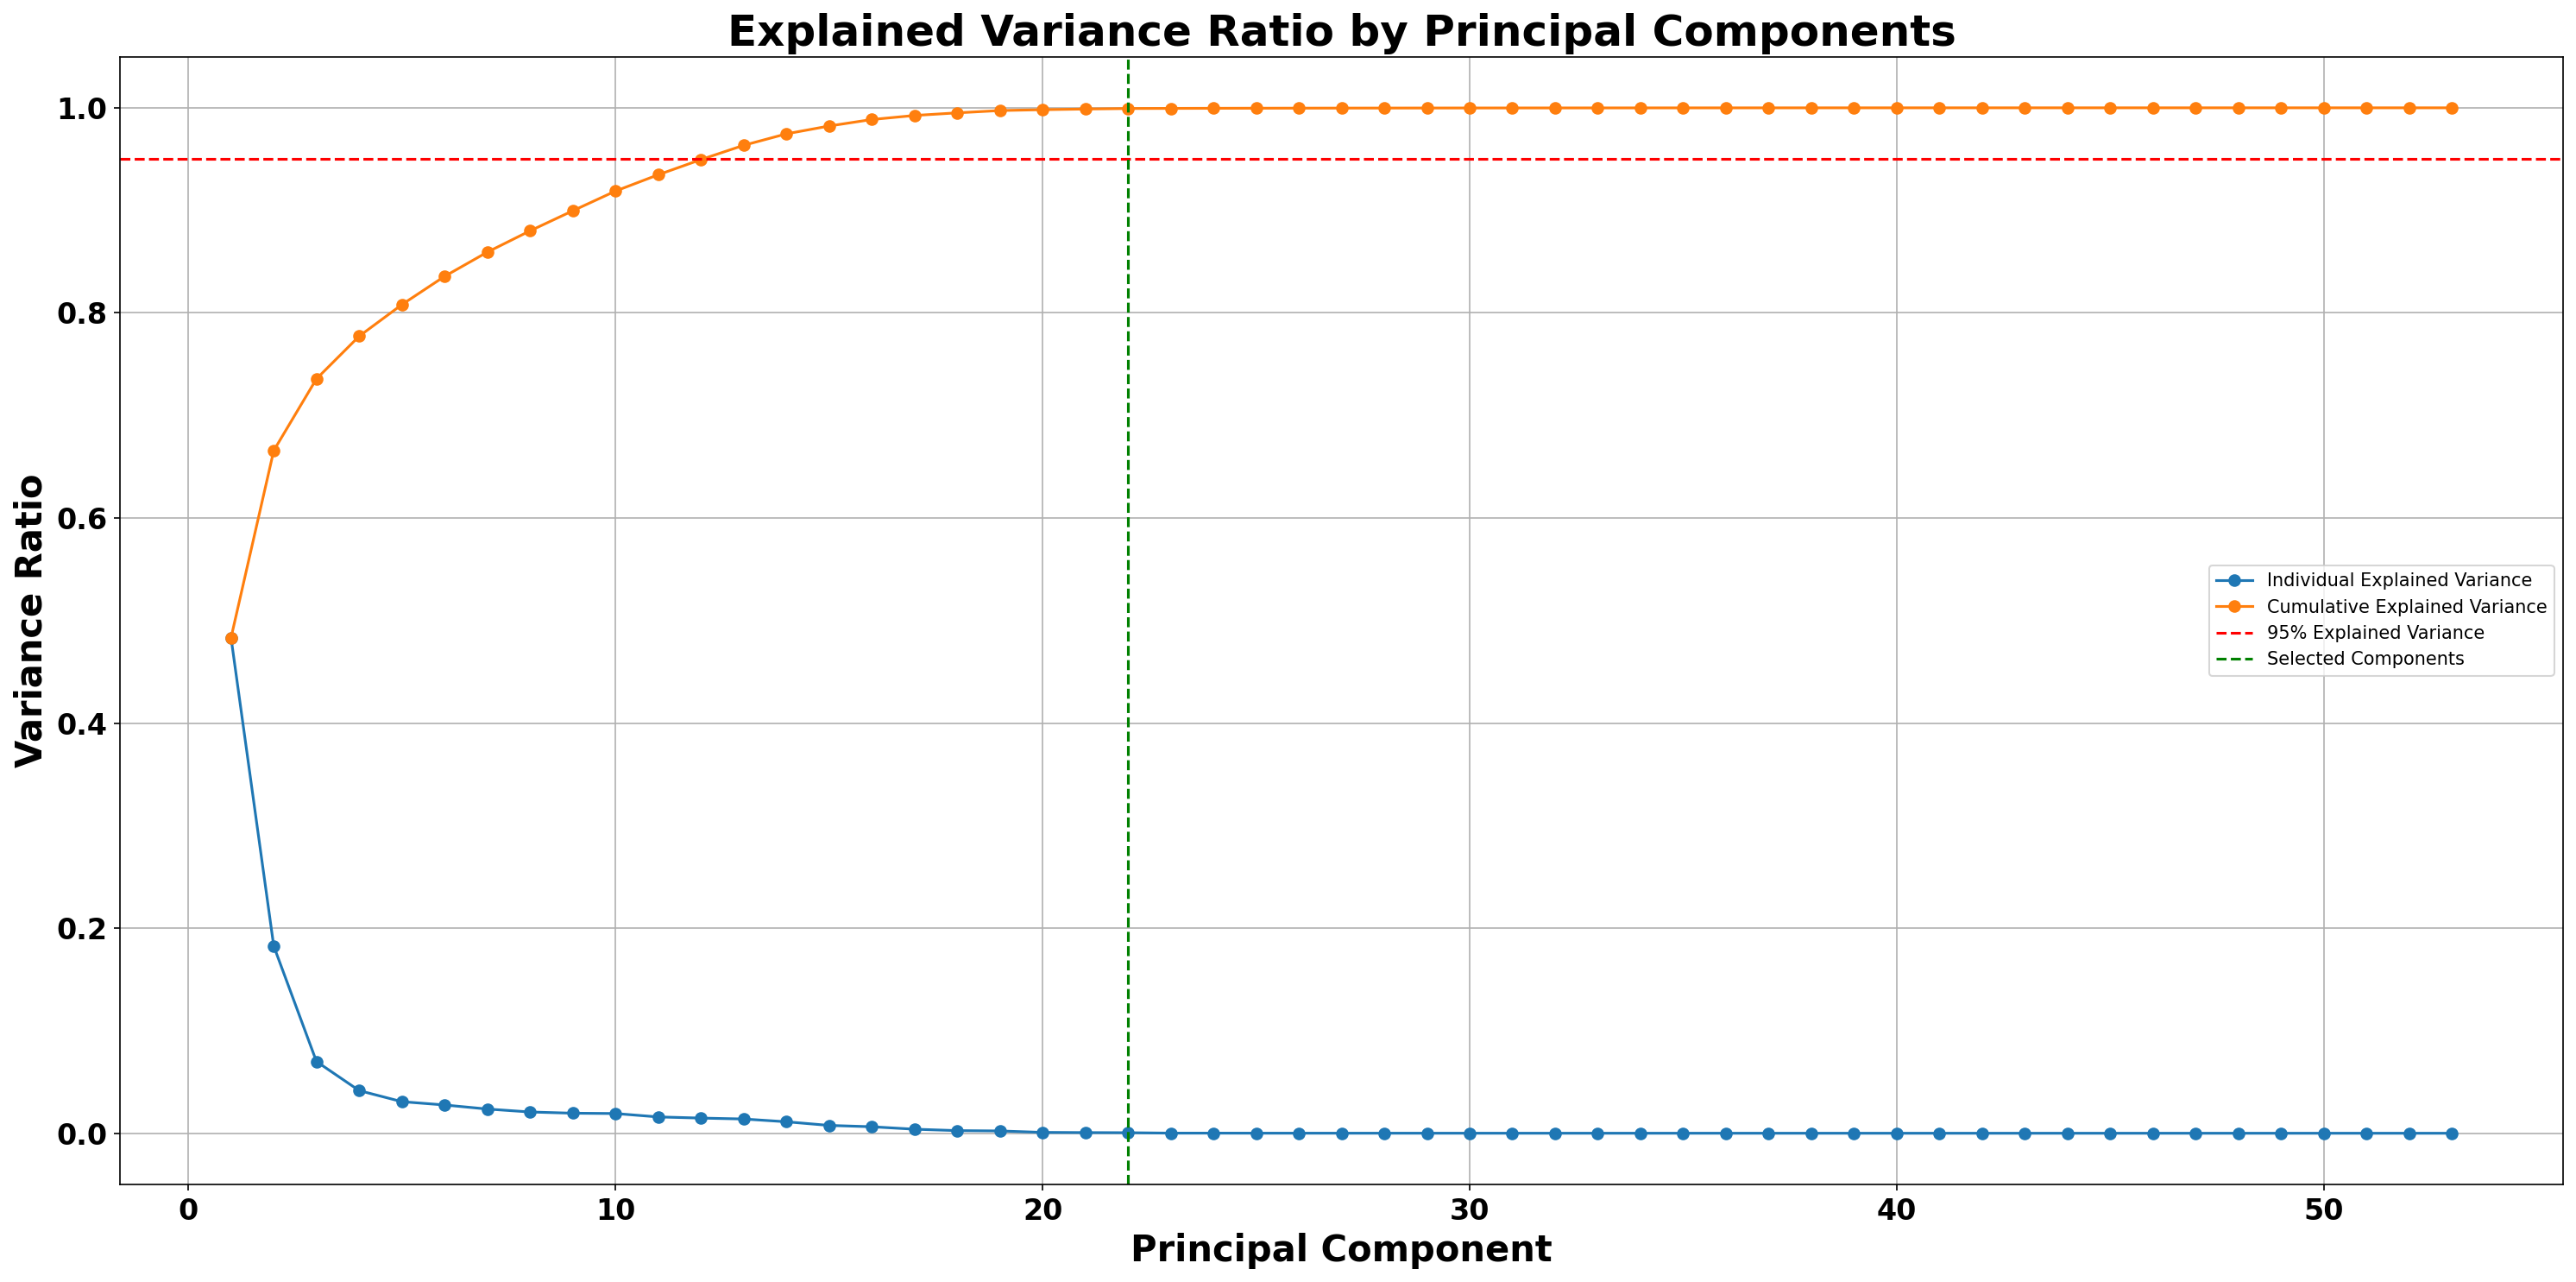

Number of principal components that explain 99.9% of the variance: 22


In [15]:
# Initialize PCA object
pca = PCA()

# Fit and transform the training data using PCA
X_pca_train = pca.fit_transform(X_train_scaled)

# Transform the validating data using PCA
X_pca_val = pca.transform(X_val_scaled)

# Transform the testing data using PCA
X_pca_test = pca.transform(X_test_scaled)

# Get the explained variance ratio for each principal component
explained_variance_ratio_scaled = pca.explained_variance_ratio_

# Get the cumulative explained variance for each principal component
cumulative_explained_variance_scaled = explained_variance_ratio_scaled.cumsum()
p_principal = 0.999
# Get the number of principal components that explain p_principal% of the variance
num_components_n_var_scaled = (
    cumulative_explained_variance_scaled <= p_principal
).sum() + 1

# Plot the explained variance ratio and cumulative explained variance
plt.figure(figsize=(20, 10), dpi=150)
plt.plot(
    range(1, len(explained_variance_ratio_scaled) + 1),
    explained_variance_ratio_scaled,
    label="Individual Explained Variance",
    marker="o",
)
plt.plot(
    range(1, len(cumulative_explained_variance_scaled) + 1),
    cumulative_explained_variance_scaled,
    label="Cumulative Explained Variance",
    marker="o",
)
plt.xlabel("Principal Component", fontweight="bold", fontsize=20)
plt.ylabel("Variance Ratio", fontweight="bold", fontsize=20)
plt.title(
    "Explained Variance Ratio by Principal Components", fontweight="bold", fontsize=24
)
plt.axhline(y=0.95, color="r", linestyle="--", label="95% Explained Variance")
plt.axvline(
    x=num_components_n_var_scaled,
    color="g",
    linestyle="--",
    label="Selected Components",
)
plt.legend()
plt.xticks(fontsize=16, fontweight="bold")
plt.yticks(fontsize=16, fontweight="bold")
plt.grid()
plt.tight_layout()
plt.show()

# Print the number of principal components and the cumulative explained variance
print(
    f"Number of principal components that explain {p_principal*100}% of the variance: {num_components_n_var_scaled}"
)

In [16]:
# Select the final principal components for the training and testing data
X_pca_final_train = X_pca_train[:, :num_components_n_var_scaled]
X_pca_final_val = X_pca_val[:, :num_components_n_var_scaled]
X_pca_final_test = X_pca_test[:, :num_components_n_var_scaled]

# Print the shapes of the training and testing data before and after PCA
print("Training and testing data shapes before PCA:")
print((X_train.shape, X_test.shape), (y_train.shape, y_test.shape))
print("Training and testing data shapes after PCA:")
print((X_pca_final_train.shape, X_pca_final_test.shape), (y_train.shape, y_test.shape))

Training and testing data shapes before PCA:
((1453, 53), (21, 53)) ((1453,), (21,))
Training and testing data shapes after PCA:
((1453, 22), (21, 22)) ((1453,), (21,))


### SVC


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found based on F1 score:  {'C': 100, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.6666666666666666
Precision: 0.7142857142857143
Recall: 0.7692307692307693
F1 Score: 0.7407407407407408
ROC AUC Score: 0.6346153846153846


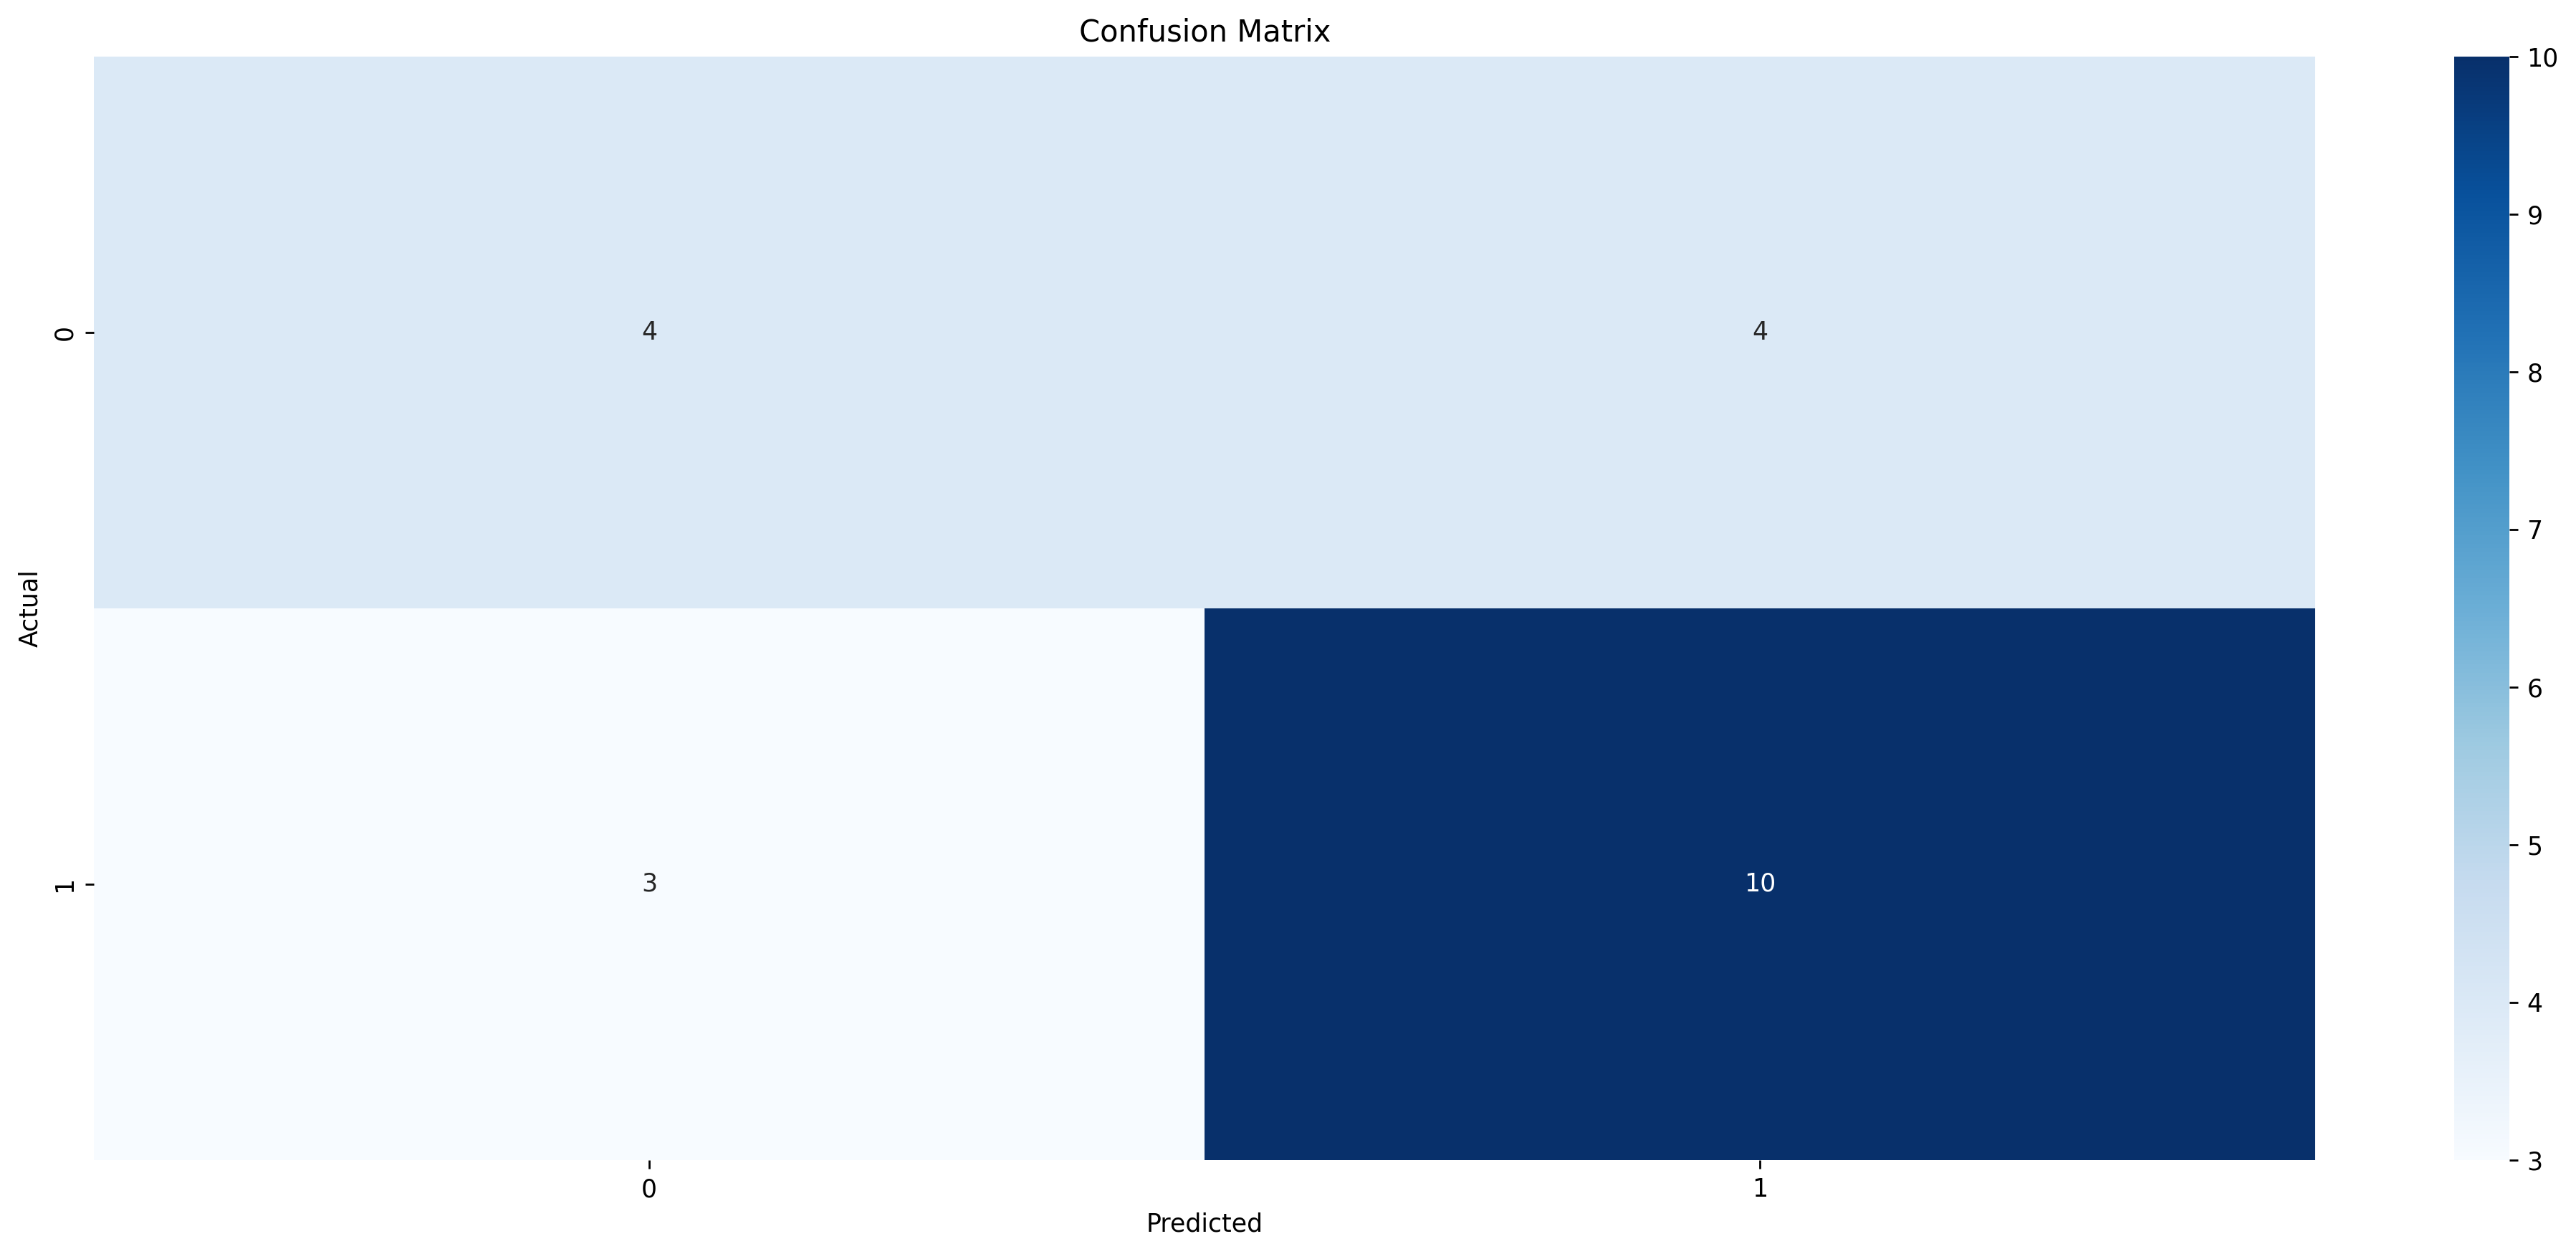

In [18]:
# Define the hyperparameters and their values to be tested
param_grid = {
    "C": [
        80,
        100,
        120,
    ],  # Penalty parameter C of the error term
    "gamma": ["scale", "auto"],  # Kernel coefficient for 'rbf'
    "kernel": [
        "linear",
        "rbf",
    ],  # Kernel type to be used in the algorithm
    "class_weight": [None],
}

# Initialize the GridSearchCV object with the hyperparameters, model, and scoring method
grid_search = GridSearchCV(
    SVC(random_state=81),
    param_grid,
    refit=True,
    verbose=1,
    scoring="r2",
    n_jobs=-1,
)

# Fit the model to the data
grid_search.fit(X_pca_final_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found based on F1 score: ", best_params)

# Use the best model to predict the test data
best_svm_model = grid_search.best_estimator_
y_pred = best_svm_model.predict(X_pca_final_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)  # Accuracy of the model
precision = precision_score(y_test, y_pred)  # Precision of the model
recall = recall_score(y_test, y_pred)  # Recall of the model
f1 = f1_score(y_test, y_pred)  # F1 score of the model
roc_auc = roc_auc_score(y_test, y_pred)  # ROC AUC score of the model

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

# Confusion Matrix
plt.figure(figsize=(20, 8), dpi=250)
conf_mat = confusion_matrix(y_test, y_pred)  # Confusion matrix of the model
sns.heatmap(conf_mat, annot=True, fmt="g", cmap="Blues")  # Plot the confusion matrix
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Random Forest


### rf with copy data


Fitting 5 folds for each of 30 candidates, totalling 150 fits


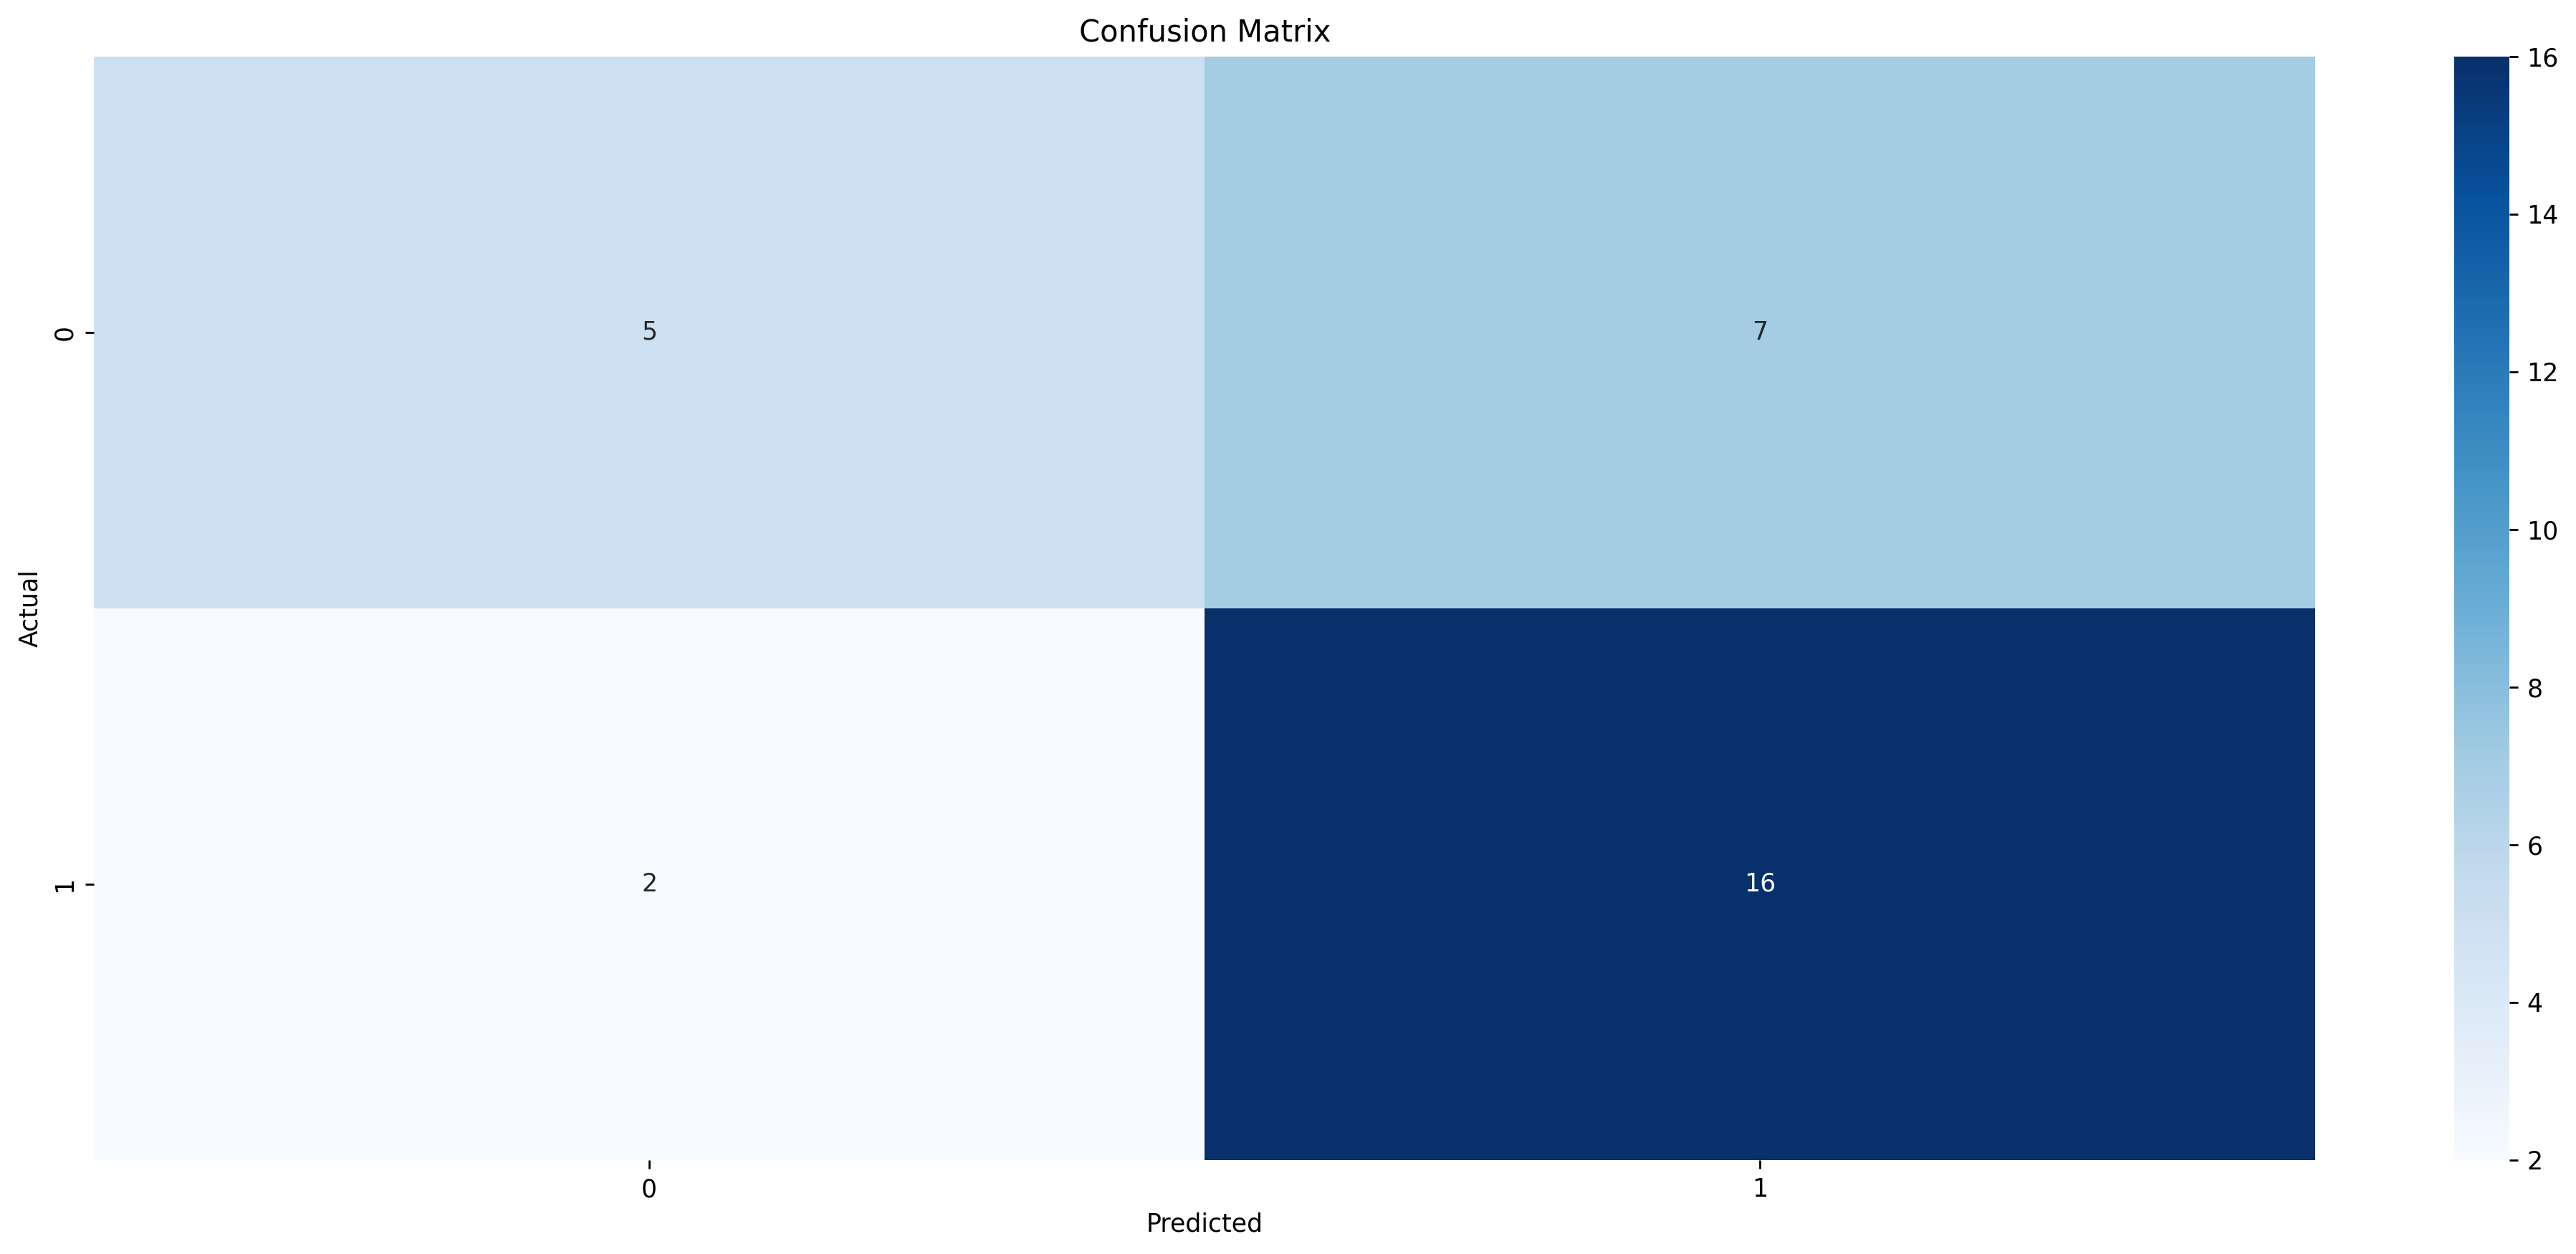

{'OOB Score': 0.5111111111111111,
 'Accuracy': 0.7,
 'Precision': 0.6956521739130435,
 'Recall': 0.8888888888888888,
 'F1 Score': 0.7804878048780488,
 'ROC AUC Score': 0.6527777777777777}

In [19]:
# Modify the RandomForestClassifier to compute the oob_score
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [None],
    "min_samples_split": [2, 5, 8, 10, 12],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True],
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=81, oob_score=True),
    param_grid,
    refit=True,
    cv=5,
    verbose=1,
    scoring="f1",
    n_jobs=-1,
)

# Fit the model to the data
grid_search.fit(X_train_scaled_copy, y_train_copy)

# Get the best parameters
best_params = grid_search.best_params_

# Use the best model to predict the test data
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test_scaled_copy)

# OOB Score for the best fit
oob_score = best_rf_model.oob_score_

# Evaluate the model
accuracy = accuracy_score(y_test_copy, y_pred)
precision = precision_score(y_test_copy, y_pred)
recall = recall_score(y_test_copy, y_pred)
f1 = f1_score(y_test_copy, y_pred)
roc_auc = roc_auc_score(y_test_copy, y_pred)

# Display the metrics
results = {
    "OOB Score": oob_score,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC AUC Score": roc_auc,
}

# Confusion Matrix
plt.figure(figsize=(20, 8), dpi=250)
conf_mat = confusion_matrix(y_test_copy, y_pred)
sns.heatmap(conf_mat, annot=True, fmt="g", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

results

### rf with bootstrap True and cv=10


Fitting 8 folds for each of 81 candidates, totalling 648 fits
Best parameters found based on F1 score:  {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 22, 'min_samples_split': 2, 'n_estimators': 250}
Accuracy: 0.5666666666666667
Precision: 0.6086956521739131
Recall: 0.7777777777777778
F1 Score: 0.6829268292682927
ROC AUC Score: 0.5138888888888888


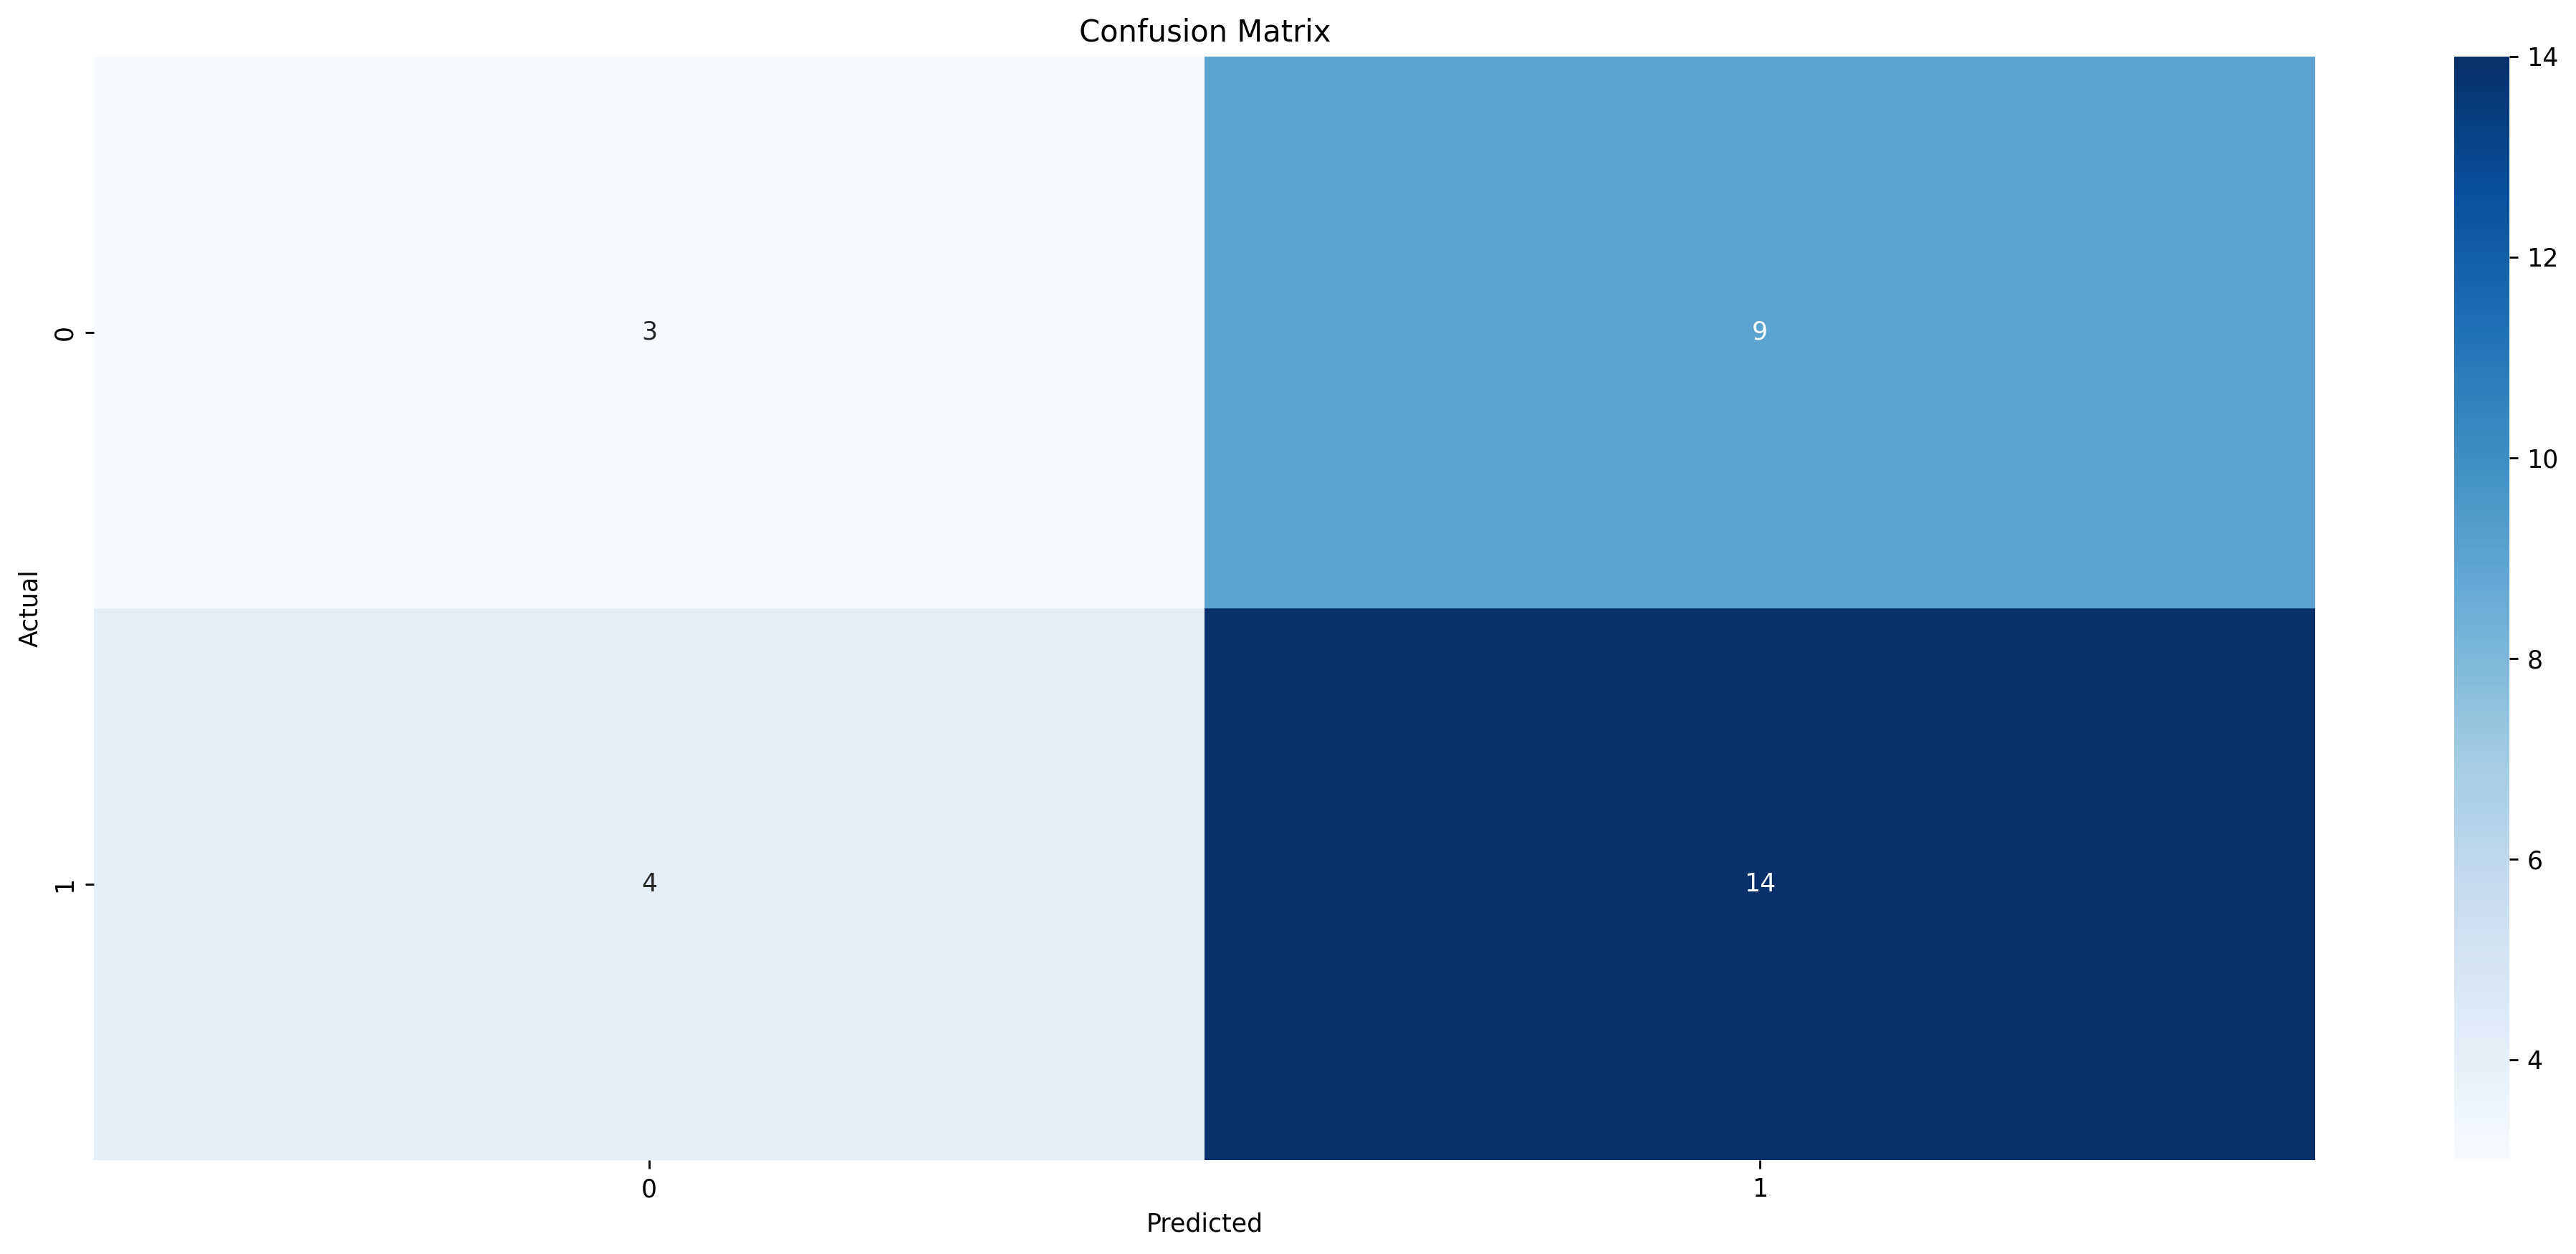

In [26]:
param_grid = {
    "n_estimators": [250, 300, 350],
    "max_depth": [30, 20, 40],
    "min_samples_split": [1, 2, 3],
    "min_samples_leaf": [18, 20, 22],
    "bootstrap": [False],
}
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=81),
    param_grid,
    refit=True,
    cv=5,
    verbose=1,
    scoring="f1",
    n_jobs=-1,
)

# Fit the model to the data
grid_search.fit(X_train_scaled_copy, y_train_copy)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found based on F1 score: ", best_params)

# Use the best model to predict the test data
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test_scaled_copy)

# Evaluate the model
accuracy = accuracy_score(y_test_copy, y_pred)
precision = precision_score(y_test_copy, y_pred)
recall = recall_score(y_test_copy, y_pred)
f1 = f1_score(y_test_copy, y_pred)
roc_auc = roc_auc_score(y_test_copy, y_pred)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

# Confusion Matrix
plt.figure(figsize=(20, 8), dpi=250)
conf_mat = confusion_matrix(y_test_copy, y_pred)  # Confusion matrix of the model
sns.heatmap(conf_mat, annot=True, fmt="g", cmap="Blues")  # Plot the confusion matrix
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters found based on F1 score:  {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.5666666666666667
Precision: 0.6086956521739131
Recall: 0.7777777777777778
F1 Score: 0.6829268292682927
ROC AUC Score: 0.5138888888888888


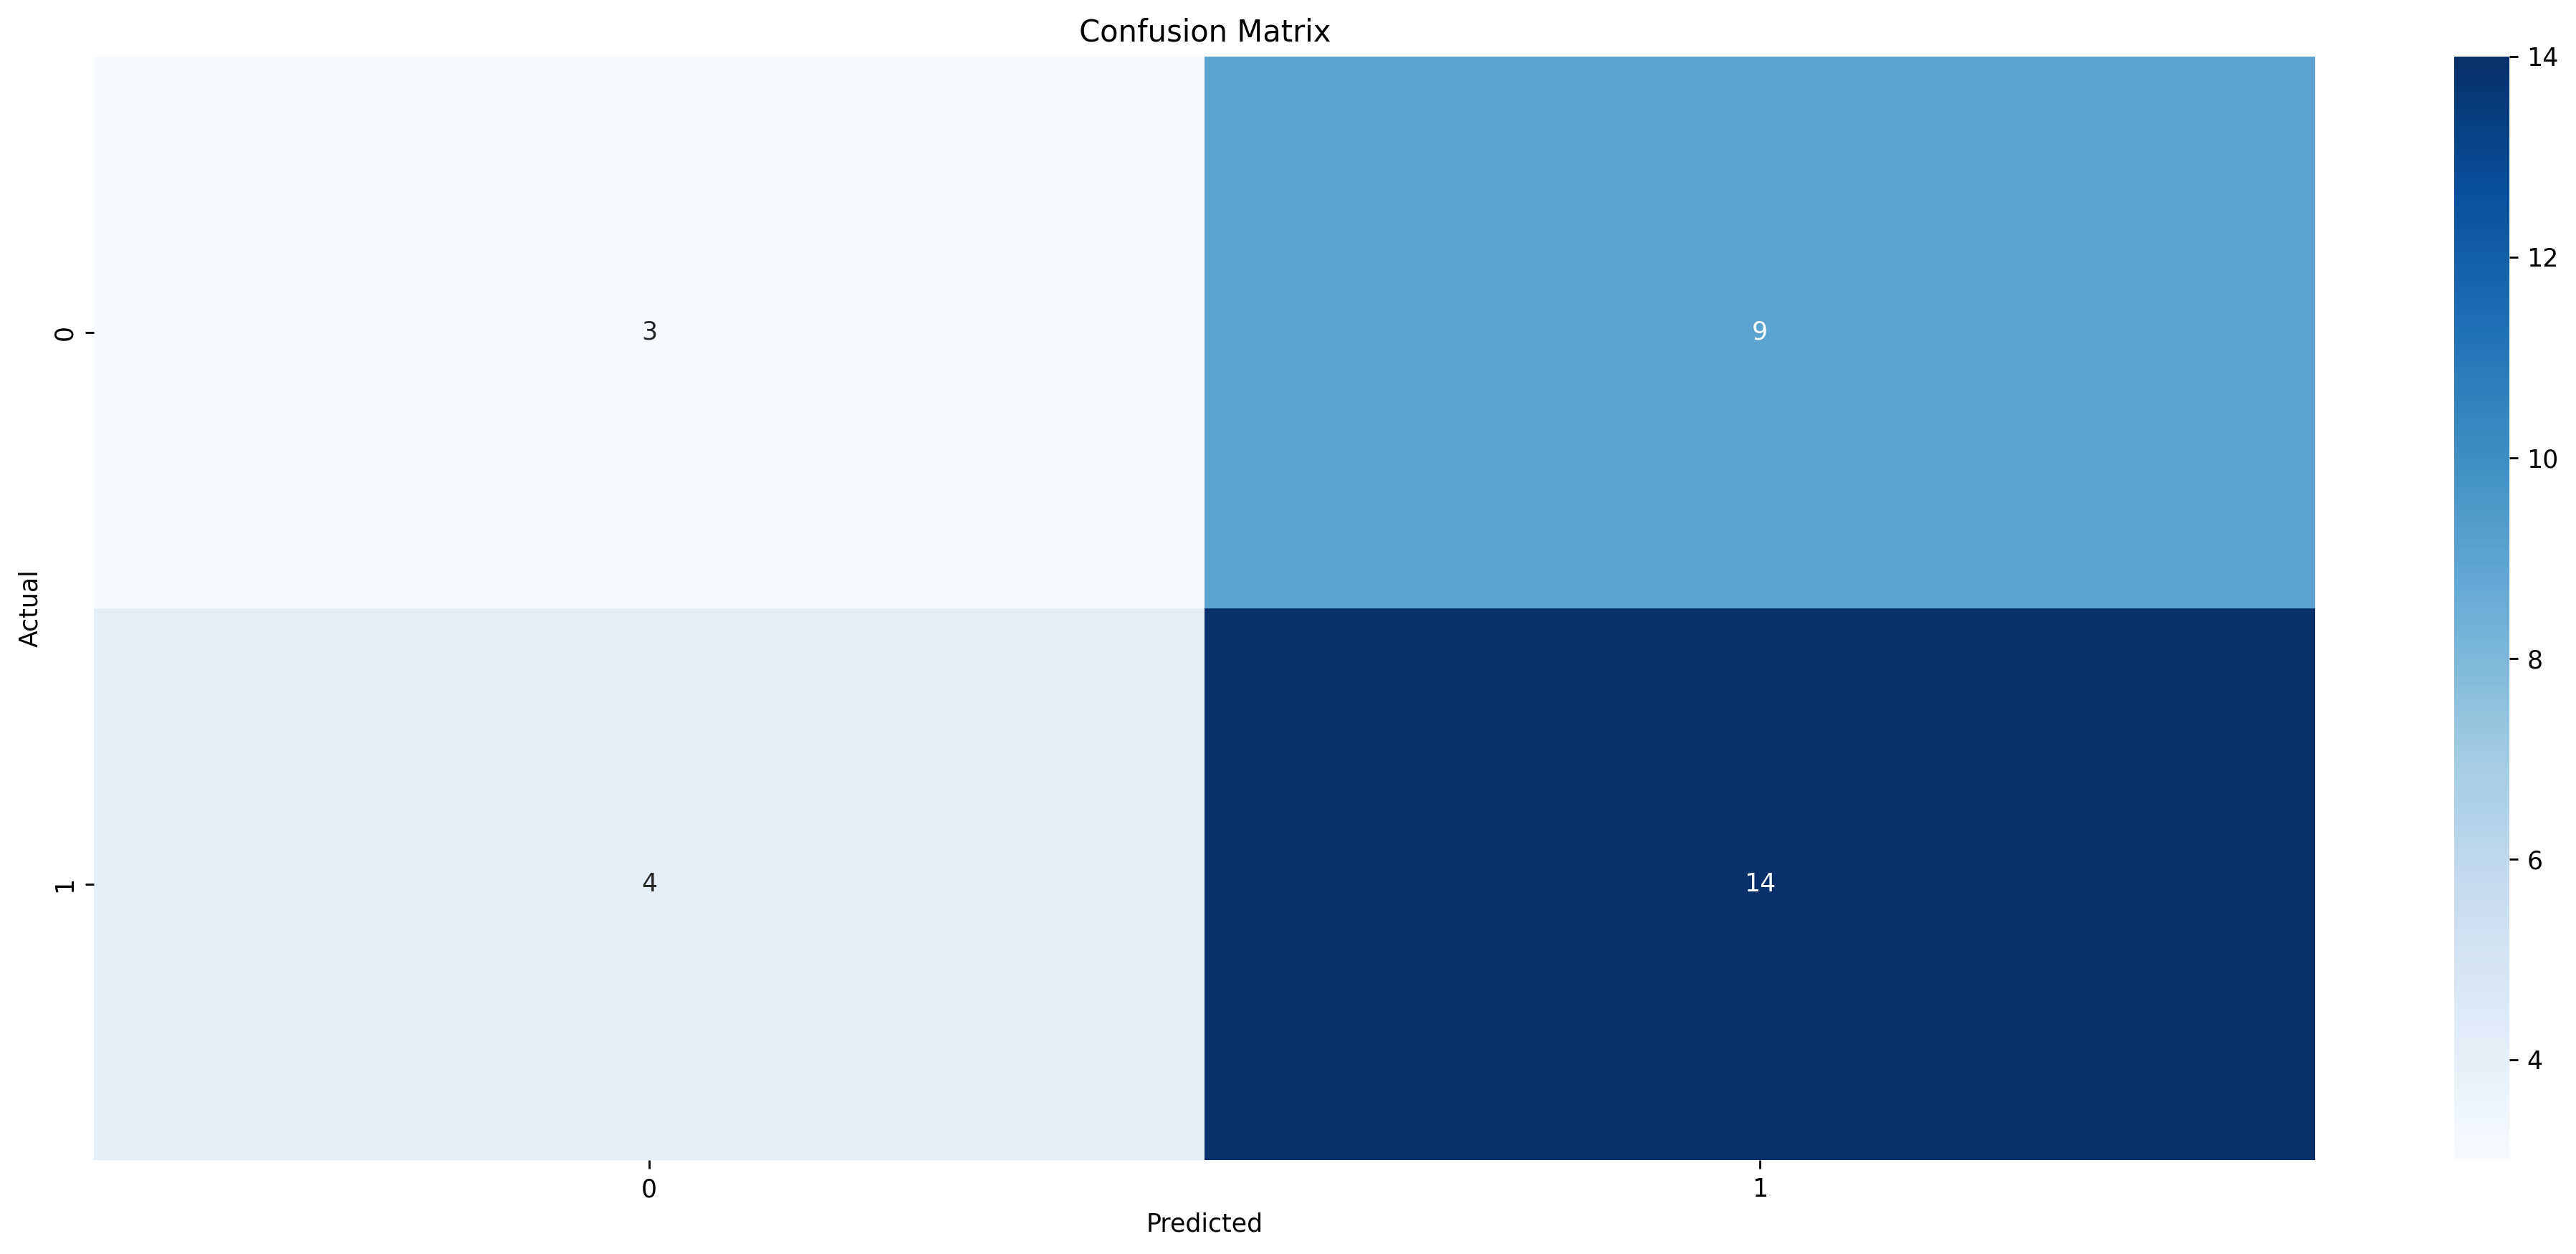

Out-of-Bag (OOB) Score: 0.5219858156028369


In [23]:
param_grid = {
    "n_estimators": [250, 300, 350],
    "max_depth": [30, 20, 40],
    "min_samples_split": [1, 2, 3],
    "min_samples_leaf": [18, 20, 22],
    "bootstrap": [False],
}
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=81, oob_score=True),
    param_grid,
    refit=True,
    cv=10,
    verbose=1,
    scoring="r2",
    n_jobs=-1,
)

# Fit the model to the data
grid_search.fit(X_train_scaled_copy, y_train_copy)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found based on F1 score: ", best_params)

# Use the best model to predict the test data
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test_scaled_copy)

# Evaluate the model
accuracy = accuracy_score(y_test_copy, y_pred)
precision = precision_score(y_test_copy, y_pred)
recall = recall_score(y_test_copy, y_pred)
f1 = f1_score(y_test_copy, y_pred)
roc_auc = roc_auc_score(y_test_copy, y_pred)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

# Confusion Matrix
plt.figure(figsize=(20, 8), dpi=250)
conf_mat = confusion_matrix(y_test_copy, y_pred)  # Confusion matrix of the model
sns.heatmap(conf_mat, annot=True, fmt="g", cmap="Blues")  # Plot the confusion matrix
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print out-of-bag (OOB) score
oob_score = best_rf_model.oob_score_
print(f"Out-of-Bag (OOB) Score: {oob_score}")

In [ ]:
# Define the hyperparameters and their values to be tested
param_grid = {
    "C": [0.0001, 0.001, 0.01],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "max_iter": [150],
    "class_weight": [None],
    "fit_intercept": [True],
    "l1_ratio": [0, 0.25],
    "penalty": ["l1", "l2"],
}

# Initialize the GridSearchCV object with the hyperparameters and model
grid_search = GridSearchCV(
    LogisticRegression(random_state=81),
    param_grid,
    refit=True,
    verbose=3,
    scoring="r2",
    n_jobs=-1,  # Use all available CPUs to speed up the search
)

# Fit the model to the data
grid_search.fit(X_pca_final_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found based on F1 score: ", best_params)

# Use the best model to predict the test data
best_logistic_model = grid_search.best_estimator_
y_pred = best_logistic_model.predict(X_pca_final_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

# Confusion Matrix
plt.figure(figsize=(20, 8), dpi=250)
conf_mat = confusion_matrix(y_test, y_pred)  # Confusion matrix of the model
sns.heatmap(conf_mat, annot=True, fmt="g", cmap="Blues")  # Plot the confusion matrix
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()